<a href="https://colab.research.google.com/github/ExoticFanta/Master_Thesis/blob/main/Simple_CNN_ensamble.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.utils import resample
from tensorflow.keras.datasets import fashion_mnist

In [ ]:
from tensorflow.keras.datasets import fashion_mnist

# Load the dataset
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

# Normalize the image pixel values to the range [0, 1]
train_images = train_images / 255.0
test_images = test_images / 255.0

# Add a channel dimension to make the shape compatible with CNNs
# Original shape: (num_samples, 28, 28), Updated shape: (num_samples, 28, 28, 1)
train_images = train_images[..., np.newaxis]
test_images = test_images[..., np.newaxis]

# Correctly extract validation images and labels
val_images = train_images[-10000:]
val_labels = train_labels[-10000:]

# Update train_images and train_labels to exclude validation data
train_images = train_images[:-10000]
train_labels = train_labels[:-10000]

print("Training data shape:", train_images.shape)
print("Training labels shape:", train_labels.shape)
print("Test data shape:", val_images.shape)
print("Test labels shape:", val_labels.shape)

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 1us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Training data shape: (50000, 28, 28, 1)
Training labels shape: (50000,)
Test data shape: (10000, 28, 28, 1)
Test labels shape: (10000,)


In [ ]:
def create_cnn():
    model = tf.keras.Sequential([
        tf.keras.layers.Conv2D(filters=32,kernel_size=3,activation='relu',input_shape = (28 , 28 , 1)),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Conv2D(filters=64,kernel_size=3,activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=2),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(150, activation='relu'),
        tf.keras.layers.Dense(10, activation='softmax')
    ])

    model.compile(optimizer='adam',
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [ ]:
model = create_cnn()
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 26, 26, 32)          │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 13, 13, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 11, 11, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 5, 5, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 1600)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 150)                 │         240,150 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 10)                  │           1,510 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 260,476 (1017.48 KB)

 Trainable params: 260,476 (1017.48 KB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
num_models = 10
models = []
histories = []

# Train each model on a bootstrapped dataset
for i in range(num_models):
    print(f"Training model {i + 1}/{num_models}...")

    # Create a bootstrapped sample of the data
    x_train_boot, y_train_boot = resample(train_images, train_labels, replace=True, n_samples=len(train_images))

    y_train_boot_encoded = tf.keras.utils.to_categorical(y_train_boot, num_classes=10)
    val_labels_encoded = tf.keras.utils.to_categorical(val_labels, num_classes=10)

    # Create and train the model
    model = create_cnn()
    history = model.fit(x_train_boot, y_train_boot_encoded,validation_data=(val_images,val_labels_encoded), epochs=7, batch_size=32, verbose=2)

    # Save the trained model to the ensemble
    models.append(model)
    histories.append(history.history)

Training model 1/10...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/7
1563/1563 - 56s - 36ms/step - accuracy: 0.8187 - loss: 0.4936 - val_accuracy: 0.8512 - val_loss: 0.3924
Epoch 2/7
1563/1563 - 81s - 52ms/step - accuracy: 0.8808 - loss: 0.3267 - val_accuracy: 0.8814 - val_loss: 0.3200
Epoch 3/7
1563/1563 - 84s - 54ms/step - accuracy: 0.8989 - loss: 0.2739 - val_accuracy: 0.8931 - val_loss: 0.2878
Epoch 4/7
1563/1563 - 80s - 51ms/step - accuracy: 0.9099 - loss: 0.2437 - val_accuracy: 0.9021 - val_loss: 0.2637
Epoch 5/7
1563/1563 - 81s - 52ms/step - accuracy: 0.9200 - loss: 0.2163 - val_accuracy: 0.9037 - val_loss: 0.2637
Epoch 6/7
1563/1563 - 84s - 54ms/step - accuracy: 0.9282 - loss: 0.1935 - val_accuracy: 0.9069 - val_loss: 0.2622
Epoch 7/7
1563/1563 - 51s - 33ms/step - accuracy: 0.9343 - loss: 0.1762 - val_accuracy: 0.9067 - val_loss: 0.2601
Training model 2/10...
Epoch 1/7
1563/1563 - 59s - 38ms/step - accuracy: 0.8177 - loss: 0.4951 - val_accuracy: 0.8672 - val_loss: 0.3659
Epoch 2/7
1563/1563 - 52s - 33ms/step - accuracy: 0.8807 - loss: 

In [ ]:
def majority_voting(models, x):
    # Get predictions from all models
    predictions = np.array([np.argmax(model.predict(x, verbose=0), axis=1) for model in models])
    # Transpose to get predictions for each sample
    predictions = predictions.T
    # Apply majority voting
    final_predictions = [np.bincount(row).argmax() for row in predictions]
    return np.array(final_predictions)

In [ ]:
y_pred = majority_voting(models, test_images)
accuracy = np.mean(y_pred == test_labels)

print(f"Ensemble Test Accuracy: {accuracy:.4f}")

Ensemble Test Accuracy: 0.9136


In [ ]:
# Accuracy and loss for each individual model
for i, model in enumerate(models):
    # Evaluate each model on the test set
    loss, accuracy = model.evaluate(test_images, tf.keras.utils.to_categorical(test_labels, num_classes=10), verbose=0)
    print(f"Model {i + 1} - Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}")

Model 1 - Test Loss: 0.2710, Test Accuracy: 0.9049
Model 2 - Test Loss: 0.2703, Test Accuracy: 0.9055
Model 3 - Test Loss: 0.2774, Test Accuracy: 0.8997
Model 4 - Test Loss: 0.2860, Test Accuracy: 0.9007
Model 5 - Test Loss: 0.2711, Test Accuracy: 0.9049
Model 6 - Test Loss: 0.2831, Test Accuracy: 0.9027
Model 7 - Test Loss: 0.2847, Test Accuracy: 0.9028
Model 8 - Test Loss: 0.2991, Test Accuracy: 0.9016
Model 9 - Test Loss: 0.2891, Test Accuracy: 0.8989
Model 10 - Test Loss: 0.2721, Test Accuracy: 0.9056


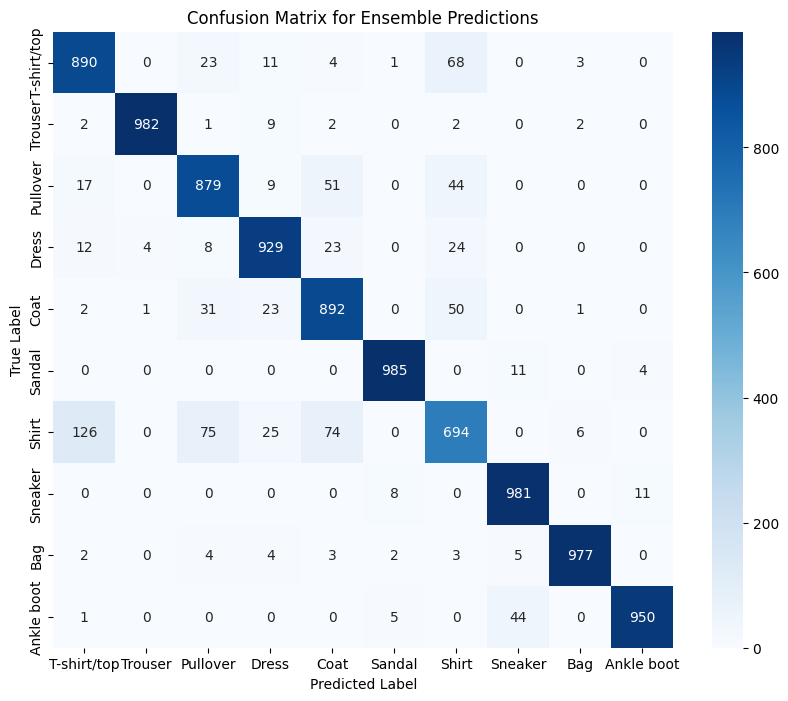


Classification Report for Ensemble:

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.89      0.87      1000
     Trouser       0.99      0.98      0.99      1000
    Pullover       0.86      0.88      0.87      1000
       Dress       0.92      0.93      0.92      1000
        Coat       0.85      0.89      0.87      1000
      Sandal       0.98      0.98      0.98      1000
       Shirt       0.78      0.69      0.74      1000
     Sneaker       0.94      0.98      0.96      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.92     10000
   macro avg       0.92      0.92      0.92     10000
weighted avg       0.92      0.92      0.92     10000



In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns


# Define class names for Fashion MNIST
class_names = [
    "T-shirt/top", "Trouser", "Pullover", "Dress", "Coat",
    "Sandal", "Shirt", "Sneaker", "Bag", "Ankle boot"
]

# Confusion matrix
conf_matrix = confusion_matrix(test_labels, y_pred)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix for Ensemble Predictions')
plt.show()

# Classification report
report = classification_report(test_labels, y_pred, target_names=class_names)
print("\nClassification Report for Ensemble:\n")
print(report)

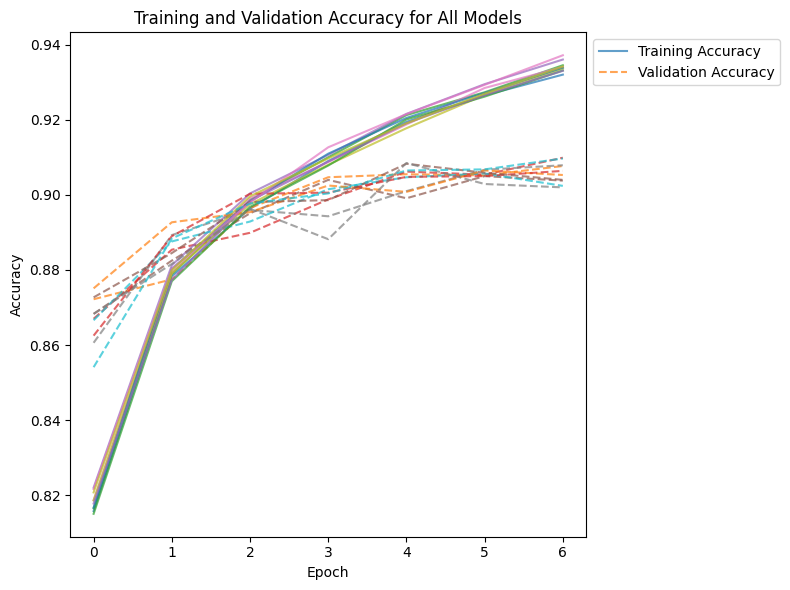

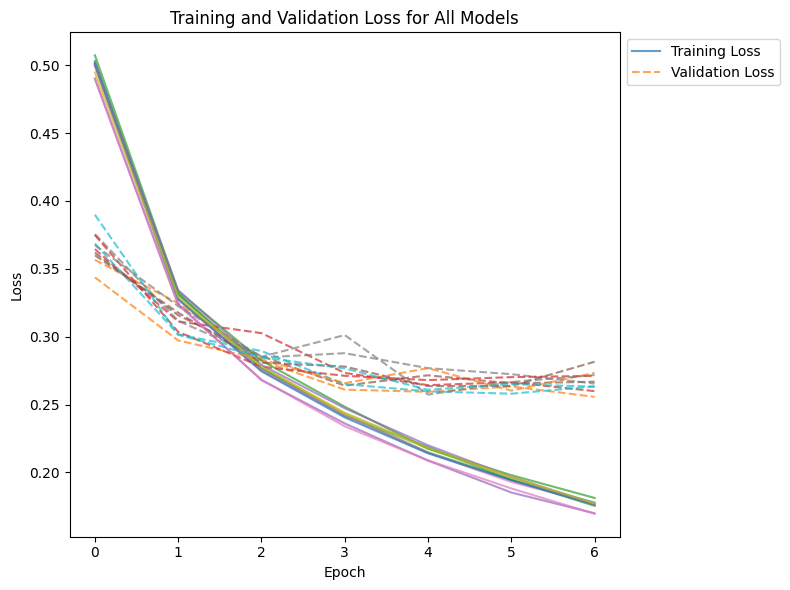

In [ ]:

# Plot training and validation accuracy
plt.figure(figsize=(8, 6))
for i, history in enumerate(histories):
    plt.plot(history['accuracy'], alpha=0.7)  # Training Accuracy
    plt.plot(history['val_accuracy'], linestyle='--', alpha=0.7)  # Validation Accuracy

plt.title('Training and Validation Accuracy for All Models')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Training Accuracy', 'Validation Accuracy'], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()

# Plot training and validation loss
plt.figure(figsize=(8, 6))
for i, history in enumerate(histories):
    plt.plot(history['loss'], alpha=0.7)  # Training Loss
    plt.plot(history['val_loss'], linestyle='--', alpha=0.7)  # Validation Loss

plt.title('Training and Validation Loss for All Models')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(['Training Loss', 'Validation Loss'], loc='upper left', bbox_to_anchor=(1, 1))
plt.tight_layout()
plt.show()


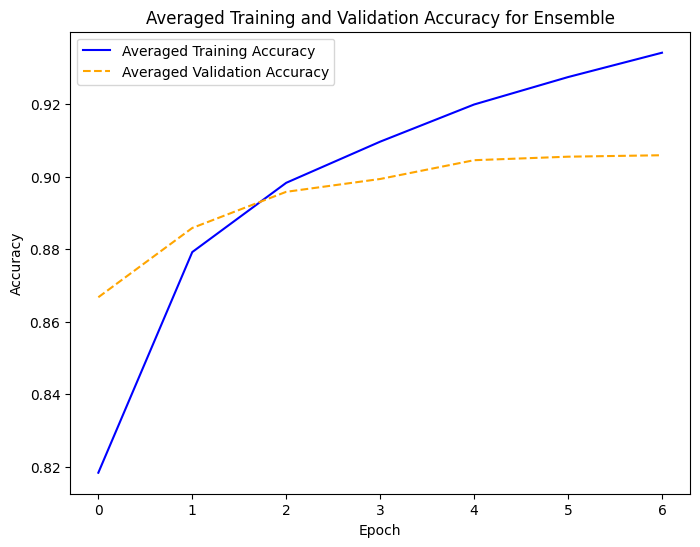

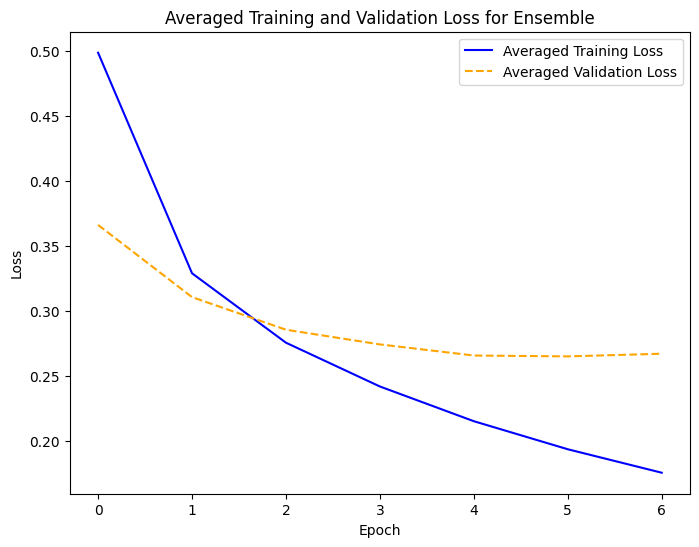

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Initialize lists to store averaged metrics
num_epochs = len(histories[0]['accuracy'])  # Assuming all models have the same number of epochs
avg_train_accuracy = np.zeros(num_epochs)
avg_val_accuracy = np.zeros(num_epochs)
avg_train_loss = np.zeros(num_epochs)
avg_val_loss = np.zeros(num_epochs)

# Compute averages
for history in histories:
    avg_train_accuracy += np.array(history['accuracy'])
    avg_val_accuracy += np.array(history['val_accuracy'])
    avg_train_loss += np.array(history['loss'])
    avg_val_loss += np.array(history['val_loss'])

# Divide by the number of models to get the mean
avg_train_accuracy /= len(histories)
avg_val_accuracy /= len(histories)
avg_train_loss /= len(histories)
avg_val_loss /= len(histories)

# Plot averaged training and validation accuracy
plt.figure(figsize=(8, 6))
plt.plot(avg_train_accuracy, label='Averaged Training Accuracy', color='blue')
plt.plot(avg_val_accuracy, label='Averaged Validation Accuracy', color='orange', linestyle='--')
plt.title('Averaged Training and Validation Accuracy for Ensemble')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Plot averaged training and validation loss
plt.figure(figsize=(8, 6))
plt.plot(avg_train_loss, label='Averaged Training Loss', color='blue')
plt.plot(avg_val_loss, label='Averaged Validation Loss', color='orange', linestyle='--')
plt.title('Averaged Training and Validation Loss for Ensemble')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


Number of 'Shirt' samples: 1000
Accuracy for 'Shirt' category: 0.70


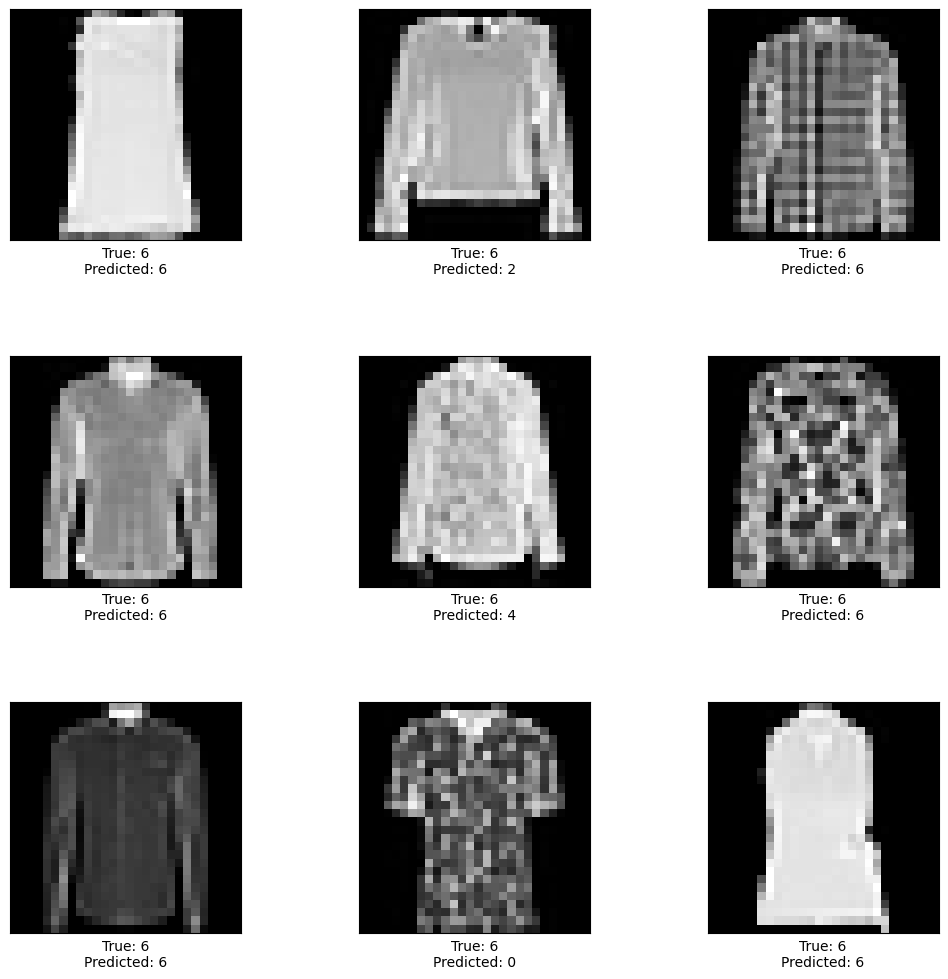

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
shirt_index = 6  # Index of "Shirt" in Fashion MNIST class labels

# Filter test data to include only "Shirt" samples
shirt_indices = np.where(test_labels == shirt_index)[0]
shirt_images = test_images[shirt_indices]
shirt_labels = test_labels[shirt_indices]

shirt_predictions = majority_voting(models, shirt_images)

# Display results
print(f"Number of 'Shirt' samples: {len(shirt_labels)}")
print(f"Accuracy for 'Shirt' category: {np.mean(shirt_predictions == shirt_labels):.2f}")

# Visualize some results
def display_shirt_samples(images, true_labels, predicted_labels):
    """Display random samples of Shirt images with true and predicted labels."""
    random_indices = np.random.choice(len(images), 9, replace=False)
    sample_images = images[random_indices]
    sample_true = true_labels[random_indices]
    sample_predicted = predicted_labels[random_indices]

    fig, axes = plt.subplots(3, 3, figsize=(12, 12))
    fig.subplots_adjust(hspace=0.5, wspace=0.5)

    for i, ax in enumerate(axes.flat):
        ax.imshow(sample_images[i].squeeze(), cmap='gray')  # Display grayscale image
        ax.set_xlabel(f"True: {sample_true[i]}\nPredicted: {sample_predicted[i]}")
        ax.set_xticks([])
        ax.set_yticks([])

    plt.show()

# Display random Shirt samples
display_shirt_samples(shirt_images, shirt_labels, shirt_predictions)